In [1]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn

In [2]:

from IPython.display import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline


The Encoder

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, vlen, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
#        self.src_embed = nn.Embedding(vlen, 512)

        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        
        #eb = self.src_embed(torch.tensor(np.random.randint(1,9, size=(2,5)), dtype=torch.long))
        eb = self.src_embed(src)
        return self.encoder(eb, src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


In [4]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

Encoder and Decoder implementation

In [5]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [7]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [8]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return self.norm(x + self.dropout(sublayer(x)))

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None


In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        
        return self.sublayer[1](x, self.feed_forward)

In [10]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [11]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout) :
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[0](x, lambda x: self.src_attn(x, m, m, src_mask))
        
        return self.sublayer[2](x, self.feed_forward)
        

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


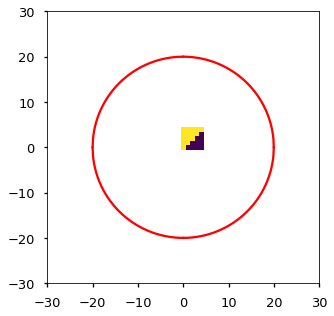

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(5)[0])
print(subsequent_mask(5))
plt.xlim([-30, 30])
plt.ylim([-30, 30])
xx = np.linspace(0, 20, 221)
yy = np.sqrt(400 - xx*xx)
plt.plot(xx, yy, color='red')
plt.plot(xx, -yy, color='red')
plt.plot(-xx, yy, color='red')
plt.plot(-xx, -yy, color='red')

None

In [14]:
def attention(query, key, value, mask= None, dropout=None):
    d_k = query.size(-1)
  
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)
    # scores = torch.matmul(query, key)/math.sqrt(d_k)
    #print("scores -->: d_q, q, k, v, scores.shape, mask.shape ", d_k, query.shape, key.shape, value.shape, scores.shape, mask.shape)

    if mask is None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    
    #print("p_attn -->:  ", p_attn.shape)
        
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    a = torch.matmul(p_attn, value)
    return torch.matmul(p_attn, value), p_attn

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        # Actually, the NN.Linear is mapping from d_model to h * d_k
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [16]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        relu_res = F.relu(self.w_1(x))
        return self.w_2(self.dropout(relu_res))

In [17]:
'''
k = torch.randn(5, 64, 24)
q = torch.randn(5, 64, 24)
v = torch.randn(5, 64, 24)

a = MultiHeadedAttention(3, 24)
res = a(q, k, v)
print(res.shape)
print(res[0][0])
ff = PositionwiseFeedForward(24, 64)
print(ff(res[0][0]))
'''

'\nk = torch.randn(5, 64, 24)\nq = torch.randn(5, 64, 24)\nv = torch.randn(5, 64, 24)\n\na = MultiHeadedAttention(3, 24)\nres = a(q, k, v)\nprint(res.shape)\nprint(res[0][0])\nff = PositionwiseFeedForward(24, 64)\nprint(ff(res[0][0]))\n'

In [18]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.luta = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
       
        return self.luta(x) * math.sqrt(self.d_model)

In [19]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(9, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"], 3], dtype=torch.long)
print(lookup_tensor)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([0, 3])
tensor([[ 0.6422, -0.6083,  0.3027,  0.6972, -1.7857],
        [ 0.5613,  0.2220, -0.5284, -0.3340,  0.7756]],
       grad_fn=<EmbeddingBackward>)


In [20]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

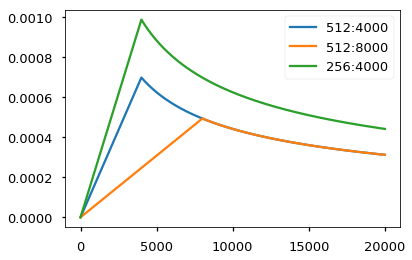

In [21]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [22]:

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [23]:

if False: 
    #Example of label smoothing.
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor([[0.1, 0.2, 0.7, 0.1, 0.1],
                             [0.1, 0.2, 0.7, 0.1, 0.3], 
                             [0.1, 0.2, 0.7, 0.1, 0.3]])
    v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

    print(predict)
    a = torch.LongTensor([2, 1, 0])
    print(crit.true_dist)
# Show the target distributions expected by the system.
    plt.imshow(crit.true_dist)
    print("res", v)

None

In [24]:


crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    a = torch.LongTensor([1])
    b = crit(Variable(predict.log()),
                 Variable(a)).data
    return b

if False:
    plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


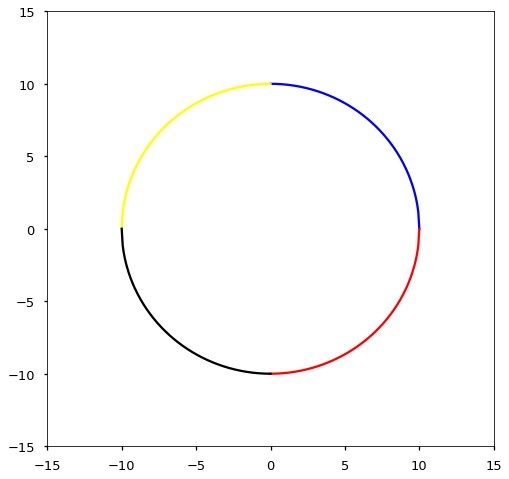

In [25]:
#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

fig = plt.figure(figsize=(8, 8))
xx = np.linspace(0,10,150)
yy = np.sqrt(100 - xx*xx)
#plt.figure(figsize=(105,105))
plt.xlim(-15,15)
plt.ylim(-15,15)

plt.plot(xx, yy, color="blue")
plt.plot(xx, -yy, color="red")
plt.plot(-xx, yy, color="yellow")
plt.plot(-xx, -yy, color="black")

In [26]:
'''
from torchtext import data, datasets


import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD='<s>'
EOS_WORD='</s>'
BLANK_WORD="<blank>"

print(tokenize_de("Shuguang Liu"))

SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token=BOS_WORD, eos_token=EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN= 100

train, val, test = datasets.IWSLT.splits(
    exts = ('.de', '.en'), 
    fields = (SRC, TGT), 
    filter_pred = lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)

MIN_FREQ=2
SRC.build_vocab(train.src, min_freq = MIN_FREQ)
TGT.build_vocab(train.trg, min_freq = MIN_FREQ)

train[0]
'''

'\nfrom torchtext import data, datasets\n\n\nimport spacy\nspacy_de = spacy.load(\'de\')\nspacy_en = spacy.load(\'en\')\n\ndef tokenize_de(text):\n    return [tok.text for tok in spacy_de.tokenizer(text)]\n\ndef tokenize_en(text):\n    return [tok.text for tok in spacy_en.tokenizer(text)]\n\nBOS_WORD=\'<s>\'\nEOS_WORD=\'</s>\'\nBLANK_WORD="<blank>"\n\nprint(tokenize_de("Shuguang Liu"))\n\nSRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)\nTGT = data.Field(tokenize=tokenize_en, init_token=BOS_WORD, eos_token=EOS_WORD, pad_token=BLANK_WORD)\n\nMAX_LEN= 100\n\ntrain, val, test = datasets.IWSLT.splits(\n    exts = (\'.de\', \'.en\'), \n    fields = (SRC, TGT), \n    filter_pred = lambda x: len(vars(x)[\'src\']) <= MAX_LEN and len(vars(x)[\'trg\']) <= MAX_LEN)\n\nMIN_FREQ=2\nSRC.build_vocab(train.src, min_freq = MIN_FREQ)\nTGT.build_vocab(train.trg, min_freq = MIN_FREQ)\n\ntrain[0]\n'

In [27]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt = None):
        self.criterion = criterion
        self.generator = generator
        self.opt = opt
        
    def __call__(self, y_model, y_real, norm):
        y_model = self.generator(y_model)
        loss = self.criterion(y_model.contiguous().view(-1, y_model.size(-1)),
                             y_real.contiguous().view(-1))/norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data * norm

In [28]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)
    

In [29]:
if False: 
    plt.figure(figsize=(15, 5))
    pe = PositionalEncoding(20, 0)
    y = pe.forward(Variable(torch.zeros(1, 100, 20)))
    plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
    plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [30]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0
    

In [31]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y !=  pad).data.sum()
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [32]:
def data_gen(Vocab_len, batch, nbatches):
    for i in range(nbatches):
        #data = torch.from_numpy(np.random.randlong(1, Vocab_len, size=(batch, 10)))
        data = torch.tensor(np.random.randint(1, Vocab_len, size=(batch, 40)), dtype=torch.long)
        data[:, 0] = 1

        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)

        yield Batch(src, tgt, 0)
aa = data_gen(20, 2, 2)


dd = torch.tensor(np.random.randint(1, 9, size=(2)), dtype=torch.long)
print(dd)
embeds = nn.Embedding(9, 5)  # 2 words in vocab, 5 dimensional embeddings
#lookup_tensor = torch.tensor([word_to_ix["hello"], 3], dtype=torch.long)
#print(lookup_tensor)
hello_embed = embeds(dd)
print(hello_embed)

for i, batch in enumerate(aa):
    print("---", batch.src.shape, batch.trg.shape, batch.trg_y.shape, batch.src_mask.shape, batch.trg_mask.shape)

tensor([1, 1])
tensor([[-2.0355,  0.0370, -0.8046,  0.9000,  0.1913],
        [-2.0355,  0.0370, -0.8046,  0.9000,  0.1913]],
       grad_fn=<EmbeddingBackward>)
--- torch.Size([2, 40]) torch.Size([2, 39]) torch.Size([2, 39]) torch.Size([2, 1, 40]) torch.Size([2, 39, 39])
--- torch.Size([2, 40]) torch.Size([2, 39]) torch.Size([2, 39]) torch.Size([2, 1, 40]) torch.Size([2, 39, 39])


In [33]:

def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    embedding = Embeddings(d_model, src_vocab)
    model = EncoderDecoder(src_vocab,
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [34]:
def run_epoch(dataiter, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    
    OUTPUTFREQ = 1
    for i, newbatch in enumerate(dataiter):
    
#        batch = Batch(newbatch.src.transpose(0,1), newbatch.trg.transpose(0,1))

        batch = newbatch
        
        out = model.forward(batch.src.cuda(), batch.trg.cuda(), 
                    batch.src_mask.cuda(), batch.trg_mask.cuda())
        loss = loss_compute(out, batch.trg_y.cuda(), batch.ntokens.cuda())
        
        total_loss += loss
        total_tokens += batch.ntokens
        
        if i % OUTPUTFREQ == 0:
            elapsed = time.time() - start
            print("Epoch %d Step: %d Loss: %f Tokens per Sec: %f" %
                    (epoch, i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0            
    return total_loss / total_tokens

In [35]:
from torchtext.data import Iterator, BucketIterator

model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
pad_idx = TGT.vocab.stoi["<blank>"]
criterion = LabelSmoothing(size = len(TGT.vocab), padding_idx=0, smoothing=0.1)

BATCHSIZE=2
model.cuda()
criterion.cuda()

train_iter = Iterator(train, batch_size=BATCHSIZE, device=0, sort=False, sort_within_batch=False,repeat=False)
val_iter = Iterator(val, batch_size=BATCHSIZE, device=0, sort=False, sort_within_batch=False,repeat=False)

model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr = 0, betas=(0.9, 0.98), eps=1e-9))
loss_compute = SimpleLossCompute(model.generator, criterion, model_opt)

for epoch in range(10) :
    model.train()

    loss = run_epoch(train_iter, model, loss_compute, epoch)
    print ("EPOCH %d --- LOSS %f ---" % (epoch, loss))



NameError: name 'SRC' is not defined

In [36]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
model.cuda()
criterion.cuda()

for epoch in range(1):
    model.train()
    run_epoch(data_gen(V, 20, 2000), model, 
              SimpleLossCompute(model.generator, criterion, model_opt), 5)
    #model.eval()
    #print(run_epoch(data_gen(V, 3, 1), model, 
    #                SimpleLossCompute(model.generator, criterion, None)))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_unifo

Epoch 5 Step: 0 Loss: 3.286941 Tokens per Sec: 0.000000
Epoch 5 Step: 1 Loss: 3.104898 Tokens per Sec: 0.000000
Epoch 5 Step: 2 Loss: 2.737241 Tokens per Sec: 0.000000
Epoch 5 Step: 3 Loss: 2.770720 Tokens per Sec: 0.000000
Epoch 5 Step: 4 Loss: 2.758015 Tokens per Sec: 0.000000
Epoch 5 Step: 5 Loss: 2.951818 Tokens per Sec: 0.000000
Epoch 5 Step: 6 Loss: 2.948008 Tokens per Sec: 0.000000
Epoch 5 Step: 7 Loss: 2.801482 Tokens per Sec: 0.000000
Epoch 5 Step: 8 Loss: 2.712562 Tokens per Sec: 0.000000
Epoch 5 Step: 9 Loss: 2.560836 Tokens per Sec: 0.000000
Epoch 5 Step: 10 Loss: 2.529102 Tokens per Sec: 0.000000
Epoch 5 Step: 11 Loss: 2.430243 Tokens per Sec: 0.000000
Epoch 5 Step: 12 Loss: 2.579729 Tokens per Sec: 0.000000
Epoch 5 Step: 13 Loss: 2.567020 Tokens per Sec: 0.000000
Epoch 5 Step: 14 Loss: 2.459217 Tokens per Sec: 0.000000
Epoch 5 Step: 15 Loss: 2.441553 Tokens per Sec: 0.000000
Epoch 5 Step: 16 Loss: 2.411847 Tokens per Sec: 0.000000
Epoch 5 Step: 17 Loss: 2.535499 Tokens pe

Epoch 5 Step: 143 Loss: 2.273351 Tokens per Sec: 0.000000
Epoch 5 Step: 144 Loss: 2.292389 Tokens per Sec: 0.000000
Epoch 5 Step: 145 Loss: 2.298217 Tokens per Sec: 0.000000
Epoch 5 Step: 146 Loss: 2.297058 Tokens per Sec: 0.000000
Epoch 5 Step: 147 Loss: 2.325291 Tokens per Sec: 0.000000
Epoch 5 Step: 148 Loss: 2.291241 Tokens per Sec: 0.000000
Epoch 5 Step: 149 Loss: 2.346834 Tokens per Sec: 0.000000
Epoch 5 Step: 150 Loss: 2.261812 Tokens per Sec: 0.000000
Epoch 5 Step: 151 Loss: 2.290804 Tokens per Sec: 0.000000
Epoch 5 Step: 152 Loss: 2.282993 Tokens per Sec: 0.000000
Epoch 5 Step: 153 Loss: 2.294928 Tokens per Sec: 0.000000
Epoch 5 Step: 154 Loss: 2.270075 Tokens per Sec: 0.000000
Epoch 5 Step: 155 Loss: 2.313720 Tokens per Sec: 0.000000
Epoch 5 Step: 156 Loss: 2.270635 Tokens per Sec: 0.000000
Epoch 5 Step: 157 Loss: 2.279902 Tokens per Sec: 0.000000
Epoch 5 Step: 158 Loss: 2.266251 Tokens per Sec: 0.000000
Epoch 5 Step: 159 Loss: 2.258581 Tokens per Sec: 0.000000
Epoch 5 Step: 

Epoch 5 Step: 284 Loss: 2.171512 Tokens per Sec: 0.000000
Epoch 5 Step: 285 Loss: 2.111876 Tokens per Sec: 0.000000
Epoch 5 Step: 286 Loss: 2.143351 Tokens per Sec: 0.000000
Epoch 5 Step: 287 Loss: 2.094581 Tokens per Sec: 0.000000
Epoch 5 Step: 288 Loss: 2.094057 Tokens per Sec: 0.000000
Epoch 5 Step: 289 Loss: 2.060319 Tokens per Sec: 0.000000
Epoch 5 Step: 290 Loss: 2.046772 Tokens per Sec: 0.000000
Epoch 5 Step: 291 Loss: 2.030835 Tokens per Sec: 0.000000
Epoch 5 Step: 292 Loss: 2.036953 Tokens per Sec: 0.000000
Epoch 5 Step: 293 Loss: 2.049743 Tokens per Sec: 0.000000
Epoch 5 Step: 294 Loss: 1.970855 Tokens per Sec: 0.000000
Epoch 5 Step: 295 Loss: 1.926220 Tokens per Sec: 0.000000
Epoch 5 Step: 296 Loss: 1.951905 Tokens per Sec: 0.000000
Epoch 5 Step: 297 Loss: 2.121368 Tokens per Sec: 0.000000
Epoch 5 Step: 298 Loss: 2.023260 Tokens per Sec: 0.000000
Epoch 5 Step: 299 Loss: 2.019725 Tokens per Sec: 0.000000
Epoch 5 Step: 300 Loss: 1.970255 Tokens per Sec: 0.000000
Epoch 5 Step: 

Epoch 5 Step: 425 Loss: 0.664570 Tokens per Sec: 0.000000
Epoch 5 Step: 426 Loss: 0.508032 Tokens per Sec: 0.000000
Epoch 5 Step: 427 Loss: 0.551468 Tokens per Sec: 0.000000
Epoch 5 Step: 428 Loss: 0.582388 Tokens per Sec: 0.000000
Epoch 5 Step: 429 Loss: 0.531923 Tokens per Sec: 0.000000
Epoch 5 Step: 430 Loss: 0.618367 Tokens per Sec: 0.000000
Epoch 5 Step: 431 Loss: 0.580806 Tokens per Sec: 0.000000
Epoch 5 Step: 432 Loss: 0.639277 Tokens per Sec: 0.000000
Epoch 5 Step: 433 Loss: 0.508641 Tokens per Sec: 0.000000
Epoch 5 Step: 434 Loss: 0.551713 Tokens per Sec: 0.000000
Epoch 5 Step: 435 Loss: 0.523523 Tokens per Sec: 0.000000
Epoch 5 Step: 436 Loss: 0.508030 Tokens per Sec: 0.000000
Epoch 5 Step: 437 Loss: 0.474712 Tokens per Sec: 0.000000
Epoch 5 Step: 438 Loss: 0.513552 Tokens per Sec: 0.000000
Epoch 5 Step: 439 Loss: 0.535875 Tokens per Sec: 0.000000
Epoch 5 Step: 440 Loss: 0.579608 Tokens per Sec: 0.000000
Epoch 5 Step: 441 Loss: 0.450645 Tokens per Sec: 0.000000
Epoch 5 Step: 

Epoch 5 Step: 566 Loss: 0.429636 Tokens per Sec: 0.000000
Epoch 5 Step: 567 Loss: 0.428800 Tokens per Sec: 0.000000
Epoch 5 Step: 568 Loss: 0.327682 Tokens per Sec: 0.000000
Epoch 5 Step: 569 Loss: 0.378134 Tokens per Sec: 0.000000
Epoch 5 Step: 570 Loss: 0.376987 Tokens per Sec: 0.000000
Epoch 5 Step: 571 Loss: 0.373987 Tokens per Sec: 0.000000
Epoch 5 Step: 572 Loss: 0.365168 Tokens per Sec: 0.000000
Epoch 5 Step: 573 Loss: 0.367124 Tokens per Sec: 0.000000
Epoch 5 Step: 574 Loss: 0.416140 Tokens per Sec: 0.000000
Epoch 5 Step: 575 Loss: 0.381091 Tokens per Sec: 0.000000
Epoch 5 Step: 576 Loss: 0.376758 Tokens per Sec: 0.000000
Epoch 5 Step: 577 Loss: 0.394044 Tokens per Sec: 0.000000
Epoch 5 Step: 578 Loss: 0.413195 Tokens per Sec: 0.000000
Epoch 5 Step: 579 Loss: 0.365188 Tokens per Sec: 0.000000
Epoch 5 Step: 580 Loss: 0.425509 Tokens per Sec: 0.000000
Epoch 5 Step: 581 Loss: 0.420667 Tokens per Sec: 0.000000
Epoch 5 Step: 582 Loss: 0.402013 Tokens per Sec: 0.000000
Epoch 5 Step: 

Epoch 5 Step: 707 Loss: 0.385908 Tokens per Sec: 0.000000
Epoch 5 Step: 708 Loss: 0.276297 Tokens per Sec: 0.000000
Epoch 5 Step: 709 Loss: 0.300117 Tokens per Sec: 0.000000
Epoch 5 Step: 710 Loss: 0.352635 Tokens per Sec: 0.000000
Epoch 5 Step: 711 Loss: 0.349404 Tokens per Sec: 0.000000
Epoch 5 Step: 712 Loss: 0.330121 Tokens per Sec: 0.000000
Epoch 5 Step: 713 Loss: 0.396145 Tokens per Sec: 0.000000
Epoch 5 Step: 714 Loss: 0.367530 Tokens per Sec: 0.000000
Epoch 5 Step: 715 Loss: 0.346199 Tokens per Sec: 0.000000
Epoch 5 Step: 716 Loss: 0.370381 Tokens per Sec: 0.000000
Epoch 5 Step: 717 Loss: 0.347349 Tokens per Sec: 0.000000
Epoch 5 Step: 718 Loss: 0.349578 Tokens per Sec: 0.000000
Epoch 5 Step: 719 Loss: 0.368376 Tokens per Sec: 0.000000
Epoch 5 Step: 720 Loss: 0.374538 Tokens per Sec: 0.000000
Epoch 5 Step: 721 Loss: 0.353198 Tokens per Sec: 0.000000
Epoch 5 Step: 722 Loss: 0.397177 Tokens per Sec: 0.000000
Epoch 5 Step: 723 Loss: 0.401658 Tokens per Sec: 0.000000
Epoch 5 Step: 

Epoch 5 Step: 848 Loss: 0.404850 Tokens per Sec: 0.000000
Epoch 5 Step: 849 Loss: 0.339731 Tokens per Sec: 0.000000
Epoch 5 Step: 850 Loss: 0.425755 Tokens per Sec: 0.000000
Epoch 5 Step: 851 Loss: 0.374078 Tokens per Sec: 0.000000
Epoch 5 Step: 852 Loss: 0.422198 Tokens per Sec: 0.000000
Epoch 5 Step: 853 Loss: 0.426051 Tokens per Sec: 0.000000
Epoch 5 Step: 854 Loss: 0.360292 Tokens per Sec: 0.000000
Epoch 5 Step: 855 Loss: 0.422101 Tokens per Sec: 0.000000
Epoch 5 Step: 856 Loss: 0.397479 Tokens per Sec: 0.000000
Epoch 5 Step: 857 Loss: 0.352397 Tokens per Sec: 0.000000
Epoch 5 Step: 858 Loss: 0.429537 Tokens per Sec: 0.000000
Epoch 5 Step: 859 Loss: 0.439504 Tokens per Sec: 0.000000
Epoch 5 Step: 860 Loss: 0.407627 Tokens per Sec: 0.000000
Epoch 5 Step: 861 Loss: 0.357154 Tokens per Sec: 0.000000
Epoch 5 Step: 862 Loss: 0.433756 Tokens per Sec: 0.000000
Epoch 5 Step: 863 Loss: 0.438856 Tokens per Sec: 0.000000
Epoch 5 Step: 864 Loss: 0.391194 Tokens per Sec: 0.000000
Epoch 5 Step: 

Epoch 5 Step: 989 Loss: 0.389599 Tokens per Sec: 0.000000
Epoch 5 Step: 990 Loss: 0.307975 Tokens per Sec: 0.000000
Epoch 5 Step: 991 Loss: 0.344993 Tokens per Sec: 0.000000
Epoch 5 Step: 992 Loss: 0.364046 Tokens per Sec: 0.000000
Epoch 5 Step: 993 Loss: 0.326992 Tokens per Sec: 0.000000
Epoch 5 Step: 994 Loss: 0.341758 Tokens per Sec: 0.000000
Epoch 5 Step: 995 Loss: 0.341185 Tokens per Sec: 0.000000
Epoch 5 Step: 996 Loss: 0.364885 Tokens per Sec: 0.000000
Epoch 5 Step: 997 Loss: 0.349429 Tokens per Sec: 0.000000
Epoch 5 Step: 998 Loss: 0.331283 Tokens per Sec: 0.000000
Epoch 5 Step: 999 Loss: 0.331765 Tokens per Sec: 0.000000
Epoch 5 Step: 1000 Loss: 0.319489 Tokens per Sec: 0.000000
Epoch 5 Step: 1001 Loss: 0.288577 Tokens per Sec: 0.000000
Epoch 5 Step: 1002 Loss: 0.327367 Tokens per Sec: 0.000000
Epoch 5 Step: 1003 Loss: 0.286380 Tokens per Sec: 0.000000
Epoch 5 Step: 1004 Loss: 0.376463 Tokens per Sec: 0.000000
Epoch 5 Step: 1005 Loss: 0.414185 Tokens per Sec: 0.000000
Epoch 5 

Epoch 5 Step: 1128 Loss: 0.314405 Tokens per Sec: 0.000000
Epoch 5 Step: 1129 Loss: 0.364483 Tokens per Sec: 0.000000
Epoch 5 Step: 1130 Loss: 0.396895 Tokens per Sec: 0.000000
Epoch 5 Step: 1131 Loss: 0.392181 Tokens per Sec: 0.000000
Epoch 5 Step: 1132 Loss: 0.358989 Tokens per Sec: 0.000000
Epoch 5 Step: 1133 Loss: 0.368068 Tokens per Sec: 0.000000
Epoch 5 Step: 1134 Loss: 0.342266 Tokens per Sec: 0.000000
Epoch 5 Step: 1135 Loss: 0.383565 Tokens per Sec: 0.000000
Epoch 5 Step: 1136 Loss: 0.376149 Tokens per Sec: 0.000000
Epoch 5 Step: 1137 Loss: 0.396810 Tokens per Sec: 0.000000
Epoch 5 Step: 1138 Loss: 0.362374 Tokens per Sec: 0.000000
Epoch 5 Step: 1139 Loss: 0.298266 Tokens per Sec: 0.000000
Epoch 5 Step: 1140 Loss: 0.318600 Tokens per Sec: 0.000000
Epoch 5 Step: 1141 Loss: 0.285828 Tokens per Sec: 0.000000
Epoch 5 Step: 1142 Loss: 0.307773 Tokens per Sec: 0.000000
Epoch 5 Step: 1143 Loss: 0.351425 Tokens per Sec: 0.000000
Epoch 5 Step: 1144 Loss: 0.374926 Tokens per Sec: 0.0000

Epoch 5 Step: 1266 Loss: 0.272018 Tokens per Sec: 0.000000
Epoch 5 Step: 1267 Loss: 0.365568 Tokens per Sec: 0.000000
Epoch 5 Step: 1268 Loss: 0.320790 Tokens per Sec: 0.000000
Epoch 5 Step: 1269 Loss: 0.324190 Tokens per Sec: 0.000000
Epoch 5 Step: 1270 Loss: 0.423097 Tokens per Sec: 0.000000
Epoch 5 Step: 1271 Loss: 0.369574 Tokens per Sec: 0.000000
Epoch 5 Step: 1272 Loss: 0.342130 Tokens per Sec: 0.000000
Epoch 5 Step: 1273 Loss: 0.377504 Tokens per Sec: 0.000000
Epoch 5 Step: 1274 Loss: 0.384430 Tokens per Sec: 0.000000
Epoch 5 Step: 1275 Loss: 0.357711 Tokens per Sec: 0.000000
Epoch 5 Step: 1276 Loss: 0.308207 Tokens per Sec: 0.000000
Epoch 5 Step: 1277 Loss: 0.380490 Tokens per Sec: 0.000000
Epoch 5 Step: 1278 Loss: 0.261545 Tokens per Sec: 0.000000
Epoch 5 Step: 1279 Loss: 0.331301 Tokens per Sec: 0.000000
Epoch 5 Step: 1280 Loss: 0.321313 Tokens per Sec: 0.000000
Epoch 5 Step: 1281 Loss: 0.289883 Tokens per Sec: 0.000000
Epoch 5 Step: 1282 Loss: 0.315681 Tokens per Sec: 0.0000

Epoch 5 Step: 1404 Loss: 0.363047 Tokens per Sec: 0.000000
Epoch 5 Step: 1405 Loss: 0.356809 Tokens per Sec: 0.000000
Epoch 5 Step: 1406 Loss: 0.307391 Tokens per Sec: 0.000000
Epoch 5 Step: 1407 Loss: 0.370146 Tokens per Sec: 0.000000
Epoch 5 Step: 1408 Loss: 0.363122 Tokens per Sec: 0.000000
Epoch 5 Step: 1409 Loss: 0.311450 Tokens per Sec: 0.000000
Epoch 5 Step: 1410 Loss: 0.336611 Tokens per Sec: 0.000000
Epoch 5 Step: 1411 Loss: 0.294948 Tokens per Sec: 0.000000
Epoch 5 Step: 1412 Loss: 0.362123 Tokens per Sec: 0.000000
Epoch 5 Step: 1413 Loss: 0.375401 Tokens per Sec: 0.000000
Epoch 5 Step: 1414 Loss: 0.288647 Tokens per Sec: 0.000000
Epoch 5 Step: 1415 Loss: 0.381690 Tokens per Sec: 0.000000
Epoch 5 Step: 1416 Loss: 0.293843 Tokens per Sec: 0.000000
Epoch 5 Step: 1417 Loss: 0.389453 Tokens per Sec: 0.000000
Epoch 5 Step: 1418 Loss: 0.341009 Tokens per Sec: 0.000000
Epoch 5 Step: 1419 Loss: 0.354358 Tokens per Sec: 0.000000
Epoch 5 Step: 1420 Loss: 0.331053 Tokens per Sec: 0.0000

Epoch 5 Step: 1542 Loss: 0.315216 Tokens per Sec: 0.000000
Epoch 5 Step: 1543 Loss: 0.320190 Tokens per Sec: 0.000000
Epoch 5 Step: 1544 Loss: 0.353323 Tokens per Sec: 0.000000
Epoch 5 Step: 1545 Loss: 0.369956 Tokens per Sec: 0.000000
Epoch 5 Step: 1546 Loss: 0.284401 Tokens per Sec: 0.000000
Epoch 5 Step: 1547 Loss: 0.322310 Tokens per Sec: 0.000000
Epoch 5 Step: 1548 Loss: 0.304399 Tokens per Sec: 0.000000
Epoch 5 Step: 1549 Loss: 0.344458 Tokens per Sec: 0.000000
Epoch 5 Step: 1550 Loss: 0.307862 Tokens per Sec: 0.000000
Epoch 5 Step: 1551 Loss: 0.344136 Tokens per Sec: 0.000000
Epoch 5 Step: 1552 Loss: 0.314241 Tokens per Sec: 0.000000
Epoch 5 Step: 1553 Loss: 0.387935 Tokens per Sec: 0.000000
Epoch 5 Step: 1554 Loss: 0.275185 Tokens per Sec: 0.000000
Epoch 5 Step: 1555 Loss: 0.327065 Tokens per Sec: 0.000000
Epoch 5 Step: 1556 Loss: 0.392594 Tokens per Sec: 0.000000
Epoch 5 Step: 1557 Loss: 0.382202 Tokens per Sec: 0.000000
Epoch 5 Step: 1558 Loss: 0.298947 Tokens per Sec: 0.0000

Epoch 5 Step: 1680 Loss: 0.399485 Tokens per Sec: 0.000000
Epoch 5 Step: 1681 Loss: 0.325282 Tokens per Sec: 0.000000
Epoch 5 Step: 1682 Loss: 0.314144 Tokens per Sec: 0.000000
Epoch 5 Step: 1683 Loss: 0.311069 Tokens per Sec: 0.000000
Epoch 5 Step: 1684 Loss: 0.307459 Tokens per Sec: 0.000000
Epoch 5 Step: 1685 Loss: 0.290176 Tokens per Sec: 0.000000
Epoch 5 Step: 1686 Loss: 0.391897 Tokens per Sec: 0.000000
Epoch 5 Step: 1687 Loss: 0.365407 Tokens per Sec: 0.000000
Epoch 5 Step: 1688 Loss: 0.387561 Tokens per Sec: 0.000000
Epoch 5 Step: 1689 Loss: 0.333233 Tokens per Sec: 0.000000
Epoch 5 Step: 1690 Loss: 0.271511 Tokens per Sec: 0.000000
Epoch 5 Step: 1691 Loss: 0.321946 Tokens per Sec: 0.000000
Epoch 5 Step: 1692 Loss: 0.342016 Tokens per Sec: 0.000000
Epoch 5 Step: 1693 Loss: 0.333583 Tokens per Sec: 0.000000
Epoch 5 Step: 1694 Loss: 0.293217 Tokens per Sec: 0.000000
Epoch 5 Step: 1695 Loss: 0.301775 Tokens per Sec: 0.000000
Epoch 5 Step: 1696 Loss: 0.332136 Tokens per Sec: 0.0000

Epoch 5 Step: 1818 Loss: 0.297749 Tokens per Sec: 0.000000
Epoch 5 Step: 1819 Loss: 0.333533 Tokens per Sec: 0.000000
Epoch 5 Step: 1820 Loss: 0.305162 Tokens per Sec: 0.000000
Epoch 5 Step: 1821 Loss: 0.317204 Tokens per Sec: 0.000000
Epoch 5 Step: 1822 Loss: 0.351329 Tokens per Sec: 0.000000
Epoch 5 Step: 1823 Loss: 0.291842 Tokens per Sec: 0.000000
Epoch 5 Step: 1824 Loss: 0.354573 Tokens per Sec: 0.000000
Epoch 5 Step: 1825 Loss: 0.270937 Tokens per Sec: 0.000000
Epoch 5 Step: 1826 Loss: 0.281353 Tokens per Sec: 0.000000
Epoch 5 Step: 1827 Loss: 0.284100 Tokens per Sec: 0.000000
Epoch 5 Step: 1828 Loss: 0.286324 Tokens per Sec: 0.000000
Epoch 5 Step: 1829 Loss: 0.316280 Tokens per Sec: 0.000000
Epoch 5 Step: 1830 Loss: 0.289801 Tokens per Sec: 0.000000
Epoch 5 Step: 1831 Loss: 0.350560 Tokens per Sec: 0.000000
Epoch 5 Step: 1832 Loss: 0.347701 Tokens per Sec: 0.000000
Epoch 5 Step: 1833 Loss: 0.326659 Tokens per Sec: 0.000000
Epoch 5 Step: 1834 Loss: 0.349654 Tokens per Sec: 0.0000

Epoch 5 Step: 1956 Loss: 0.318014 Tokens per Sec: 0.000000
Epoch 5 Step: 1957 Loss: 0.332548 Tokens per Sec: 0.000000
Epoch 5 Step: 1958 Loss: 0.341527 Tokens per Sec: 0.000000
Epoch 5 Step: 1959 Loss: 0.338669 Tokens per Sec: 0.000000
Epoch 5 Step: 1960 Loss: 0.342590 Tokens per Sec: 0.000000
Epoch 5 Step: 1961 Loss: 0.325684 Tokens per Sec: 0.000000
Epoch 5 Step: 1962 Loss: 0.292293 Tokens per Sec: 0.000000
Epoch 5 Step: 1963 Loss: 0.334461 Tokens per Sec: 0.000000
Epoch 5 Step: 1964 Loss: 0.332790 Tokens per Sec: 0.000000
Epoch 5 Step: 1965 Loss: 0.311060 Tokens per Sec: 0.000000
Epoch 5 Step: 1966 Loss: 0.351512 Tokens per Sec: 0.000000
Epoch 5 Step: 1967 Loss: 0.270782 Tokens per Sec: 0.000000
Epoch 5 Step: 1968 Loss: 0.284103 Tokens per Sec: 0.000000
Epoch 5 Step: 1969 Loss: 0.332288 Tokens per Sec: 0.000000
Epoch 5 Step: 1970 Loss: 0.333702 Tokens per Sec: 0.000000
Epoch 5 Step: 1971 Loss: 0.302106 Tokens per Sec: 0.000000
Epoch 5 Step: 1972 Loss: 0.327512 Tokens per Sec: 0.0000